In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.models import resnet18, resnet34, resnet50
from tqdm import tqdm
from collections import Counter
from info_nce import InfoNCE
import matplotlib.colors as mcolors
from sklearn.metrics import precision_score, recall_score


import os
import pandas as pd
import einops
from scipy.stats import mode
import torch.optim as optim
from sklearn.metrics import f1_score
import sys
from torch.utils import data

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import src.config, src.utils, src.models, src.data
import torchvision
from torch.utils.data import random_split

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import random

from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from torch.nn import GRU, Linear, CrossEntropyLoss
from torch.optim import Adam

print("torchvision version:", torchvision.__version__)

torchvision version: 0.17.0


In [3]:
config_path = 'params/selfPAB_downstream_experiments/selfPAB_downstream_harth/config.yml'
config = src.config.Config(config_path)
args = src.utils.grid_search(config.ALGORITHM_ARGS)[0]
args.update({'input_dim': 156,
            'output_dim': 12,
            'total_step_count': 10})

feature_model = src.models.get_model(
        algorithm_name=config.ALGORITHM,
        algorithm_args=args
    )

No output activation
Softmax output activation


In [4]:
# Set all seeds:
# torch.manual_seed(config.SEED)
# torch.cuda.manual_seed(config.SEED)
# torch.cuda.manual_seed_all(config.SEED)
# np.random.seed(config.SEED)
# np.random.seed(config.SEED)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True
ds_path = 'data/harth'
ds_path = config.TRAIN_DATA if ds_path is None else ds_path
cmat_path = f'{config.CONFIG_PATH}/cmats/'
if config.VALID_SPLIT=='test':
    valid_subjects = config.TEST_SUBJECTS.copy()
    valid_split = 0.0
elif type(config.VALID_SPLIT) == list:
    valid_subjects = config.VALID_SPLIT
    valid_split = 0.0
else:
    valid_subjects = None
    valid_split = config.VALID_SPLIT
current_iter = 0
best_model = None
best_cmat = None
best_score = None
best_args = None
best_logs = None
loso=False

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms(True)

In [6]:
class SequentialRandomSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size


    def __iter__(self):
        

        indices = list(range(len(self.data_source)))
        
        remaining = len(indices) % self.batch_size
        if remaining > 0:
            indices = indices[:-remaining]
        final_indices = np.reshape(indices, (-1, self.batch_size))

        # Shuffle the batches
        np.random.shuffle(final_indices)

        # Flatten the list of batches to get the final order of indices
        final_indices = [idx for batch in final_indices for idx in batch]
        
        return iter(final_indices)

    def __len__(self):
        return len(self.data_source)

In [7]:
# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)

In [8]:
for ds_args in src.utils.grid_search(config.DATASET_ARGS):
    # Iterate over all model configs if given
    for args in src.utils.grid_search(config.ALGORITHM_ARGS):
        ######### Train with given args ##########
        
        # Create the dataset
        dataset = src.data.get_dataset(
                dataset_name=config.DATASET,
                dataset_args=ds_args,
                root_dir=ds_path,
                num_classes=config.num_classes,
                label_map=config.label_index,
                replace_classes=config.replace_classes,
                config_path=config.CONFIG_PATH,
                name_label_map=config.class_name_label_map
            )
        
        valid_split = config.VALID_SPLIT
        
        valid_amount = int(np.floor(len(dataset)*valid_split))
        train_amount = len(dataset) - valid_amount
        
        train_indices = list(range(train_amount))
        valid_indices = list(range(train_amount, train_amount + valid_amount))
        
        # Create subsets
        train_ds = Subset(dataset, train_indices)
        valid_ds = Subset(dataset, valid_indices)
        
        args["batch_size"] = 8
        train_loader = torch.utils.data.DataLoader(
            dataset=train_ds,
            batch_size=args['batch_size'],
            sampler=SequentialRandomSampler(train_ds, args['batch_size']),
#             shuffle = True,
            num_workers=config.NUM_WORKERS,
            drop_last = True,
        )
        
        valid_loader = torch.utils.data.DataLoader(
            dataset=valid_ds,
            batch_size=args['batch_size'],
#             sampler=SequentialRandomSampler(valid_ds, args['batch_size']),
            shuffle = False,
            num_workers=config.NUM_WORKERS,
            drop_last = True,
        )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:05<00:00,  3.92it/s]


In [9]:
valid_split

0.2

In [10]:
len(train_ds)

8539

In [11]:
len(valid_ds)

2134

In [12]:
train_ds[0][0].shape

torch.Size([119, 156])

In [13]:
# Create a DataLoader to iterate over the dataset
data_loader = DataLoader(train_ds, batch_size=512, shuffle=False)

# Initialize a list to store all labels
all_labels = []

# Iterate over the DataLoader to collect all labels
for _, labels in data_loader:
    all_labels.extend(labels.numpy())  # Convert the labels to numpy and extend the list

# Convert the list of labels to a numpy array
tall_labels = np.array(all_labels)

# Get unique labels and their counts
unique_labels, counts = np.unique(tall_labels, return_counts=True)

# Print the results
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} occurrences")

Label 0: 190002 occurrences
Label 1: 14709 occurrences
Label 2: 41960 occurrences
Label 3: 10318 occurrences
Label 4: 9471 occurrences
Label 5: 128066 occurrences
Label 6: 501639 occurrences
Label 7: 65924 occurrences
Label 8: 44316 occurrences
Label 9: 4168 occurrences
Label 10: 5287 occurrences
Label 11: 281 occurrences


In [14]:
# Create a DataLoader to iterate over the dataset
data_loader = DataLoader(valid_ds, batch_size=512, shuffle=False)

# Initialize a list to store all labels
all_labels = []

# Iterate over the DataLoader to collect all labels
for _, labels in data_loader:
    all_labels.extend(labels.numpy())  # Convert the labels to numpy and extend the list

# Convert the list of labels to a numpy array
vall_labels = np.array(all_labels)

# Get unique labels and their counts
unique_labels, counts = np.unique(vall_labels, return_counts=True)

# Print the results
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} occurrences")

Label 0: 46345 occurrences
Label 1: 42668 occurrences
Label 2: 6838 occurrences
Label 3: 4213 occurrences
Label 4: 3679 occurrences
Label 5: 15264 occurrences
Label 6: 71297 occurrences
Label 7: 18929 occurrences
Label 8: 33766 occurrences
Label 9: 6904 occurrences
Label 10: 2831 occurrences
Label 11: 1212 occurrences


In [15]:
def count_consecutive_labels(labels):
    if len(labels) == 0:
        return []

    result = []
    current_label = labels[0]
    count = 1

    for i in range(1, len(labels)):
        if labels[i] == current_label:
            count += 1
        else:
            result.append((current_label, count))
            current_label = labels[i]
            count = 1

    # Append the last label count
    result.append((current_label, count))
    return result

labels = vall_labels.reshape(-1)
consecutive_counts = count_consecutive_labels(labels)

for label, count in consecutive_counts:
    print(f"Label {label}: {count} times")

Label 0: 573 times
Label 1: 22 times
Label 0: 73 times
Label 1: 46 times
Label 0: 49 times
Label 1: 70 times
Label 0: 25 times
Label 1: 94 times
Label 0: 1 times
Label 1: 949 times
Label 0: 2 times
Label 1: 93 times
Label 0: 26 times
Label 1: 69 times
Label 0: 50 times
Label 1: 45 times
Label 0: 74 times
Label 1: 21 times
Label 0: 2455 times
Label 5: 16 times
Label 0: 79 times
Label 5: 16 times
Label 0: 79 times
Label 5: 16 times
Label 0: 79 times
Label 5: 16 times
Label 0: 79 times
Label 5: 16 times
Label 0: 446 times
Label 1: 14 times
Label 0: 81 times
Label 1: 38 times
Label 0: 57 times
Label 1: 62 times
Label 0: 33 times
Label 1: 86 times
Label 0: 9 times
Label 1: 820 times
Label 0: 4 times
Label 1: 91 times
Label 0: 28 times
Label 1: 67 times
Label 0: 52 times
Label 1: 43 times
Label 0: 76 times
Label 1: 19 times
Label 0: 1029 times
Label 2: 7 times
Label 5: 16 times
Label 0: 72 times
Label 2: 7 times
Label 5: 17 times
Label 2: 5 times
Label 5: 18 times
Label 0: 48 times
Label 2: 

In [16]:
class FeatureProjector(nn.Module):
    def __init__(self, input_size=156, output_size=32):
        super(FeatureProjector, self).__init__()
        
        # 1D Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=output_size, kernel_size=1)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(output_size)
        
    def forward(self, x):
        # Input x shape: (batch_size, sequence_length, input_size)
        
        # Permute to match Conv1D input: (batch_size, input_size, sequence_length)
        x = x.permute(0, 2, 1)
        
        # First convolutional layer
        x = self.conv1(x)  # Shape: (batch_size, 128, sequence_length)
        x = self.bn1(x)
        x = F.relu(x)
        
        # Second convolutional layer
        x = self.conv2(x)  # Shape: (batch_size, 64, sequence_length)
        x = self.bn2(x)
        x = F.relu(x)
        
        # Third convolutional layer
        x = self.conv3(x)  # Shape: (batch_size, output_size, sequence_length)
        x = self.bn3(x)
        x = F.relu(x)
        
        # Permute back to original order: (batch_size, sequence_length, output_size)
        x = x.permute(0, 2, 1)
        
        return x

In [17]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def initialize_model_supervised(seed):
    set_seed(seed)
    model = FeatureProjector(input_size=156, output_size=12)
    return model

In [18]:
# Instantiate the model
seed = 42
attn_model = initialize_model_supervised(seed)

In [19]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(attn_model.parameters(), lr=0.001)  # Example optimizer

# Move model to device
device = torch.device("cpu" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu")
attn_model.to(device)

# Training and validation loop
num_epochs = 5
for epoch in range(num_epochs):
    # Training phase
    attn_model.train()  # Set the model to training mode
    train_running_loss = 0.0
    train_correct_predictions = 0
    train_total_samples = 0
    
    all_preds = []
    all_labels = []
    
    for time_series, labels in tqdm(train_loader):
        time_series = time_series.to(device)
        labels = labels.to(device)
        
        # Forward pass
        features = attn_model(time_series)

        # Flatten y_hat to have dimensions [batch_size * sequence_length, num_classes]
        y_hat_flat = features.reshape(-1, features.size(-1))

        # Reshape y to have dimensions [batch_size * sequence_length]
        labels_flat = labels.view(-1)
        
        # Compute training loss
        train_loss = criterion(y_hat_flat, labels_flat)

        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Update training statistics
        train_running_loss += train_loss.item() * time_series.size(0)
        
        _, predicted = torch.max(y_hat_flat, 1)
        train_correct_predictions += (predicted == labels_flat).sum().item()
        
        #Store the labels for future computation of F1-score
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_flat.cpu().numpy())
        
        train_total_samples += labels_flat.size(0)
    
    # Calculate average training loss and accuracy for the epoch
    train_epoch_loss = train_running_loss / len(train_loader.dataset)
    train_epoch_accuracy = 100*train_correct_predictions / train_total_samples
    
    f1 = f1_score(all_labels, all_preds,average='weighted')
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_epoch_loss:.4f},\
          Train Accuracy: {train_epoch_accuracy:.2f}%, F1-score: {f1:.4f}")

    # Validation phase
    attn_model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0
    
    with torch.no_grad():
        val_preds = []
        val_labels = []
        for time_series, labels in tqdm(valid_loader):
            time_series = time_series.to(device)
            labels = labels.to(device)

            # Forward pass
            features = attn_model(time_series)

            # Flatten y_hat to have dimensions [batch_size * sequence_length, num_classes]
            y_hat_flat = features.reshape(-1, features.size(-1))

            # Reshape y to have dimensions [batch_size * sequence_length]
            labels_flat = labels.view(-1)

            # Compute validation loss
            val_loss = criterion(y_hat_flat, labels_flat)

            # Update validation statistics
            val_running_loss += val_loss.item() * time_series.size(0)
            
            _, predicted = torch.max(y_hat_flat, 1)
            val_correct_predictions += (predicted == labels_flat).sum().item()
            val_total_samples += labels_flat.size(0)
            
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels_flat.cpu().numpy())
    
    # Calculate average validation loss and accuracy for the epoch
    val_epoch_loss = val_running_loss / len(valid_loader.dataset)
    val_epoch_accuracy = 100*val_correct_predictions / val_total_samples
    
    f1 = f1_score(val_labels, val_preds, average='weighted')
    print(f"Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_epoch_loss:.4f},\
          Val Accuracy: {val_epoch_accuracy:.2f}%, F1-score: {f1:.2f}")

print("Training and validation complete.")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1067/1067 [00:29<00:00, 35.89it/s]


Epoch 1/5, Train Loss: 2.0784,          Train Accuracy: 42.37%, F1-score: 0.4158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:21<00:00, 12.37it/s]


Epoch 1/5, Val Loss: 1.6301,          Val Accuracy: 56.59%, F1-score: 0.46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1067/1067 [00:26<00:00, 39.79it/s]


Epoch 2/5, Train Loss: 1.7898,          Train Accuracy: 52.07%, F1-score: 0.4819


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:23<00:00, 11.28it/s]


Epoch 2/5, Val Loss: 1.7336,          Val Accuracy: 43.99%, F1-score: 0.28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1067/1067 [00:27<00:00, 39.45it/s]


Epoch 3/5, Train Loss: 1.6211,          Train Accuracy: 55.81%, F1-score: 0.5055


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:23<00:00, 11.14it/s]


Epoch 3/5, Val Loss: 1.7140,          Val Accuracy: 50.04%, F1-score: 0.38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1067/1067 [00:26<00:00, 40.81it/s]


Epoch 4/5, Train Loss: 1.5032,          Train Accuracy: 58.57%, F1-score: 0.5290


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:21<00:00, 12.50it/s]


Epoch 4/5, Val Loss: 1.4572,          Val Accuracy: 42.78%, F1-score: 0.34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1067/1067 [00:25<00:00, 41.32it/s]


Epoch 5/5, Train Loss: 1.4184,          Train Accuracy: 60.29%, F1-score: 0.5445


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:20<00:00, 12.89it/s]

Epoch 5/5, Val Loss: 1.2181,          Val Accuracy: 63.05%, F1-score: 0.54
Training and validation complete.


In [20]:
# Function to apply PCA and visualize the results
def visualize_pca(images, labels, class_names, model):
    # Flatten the images to vectors (assuming they are 2D images)
#     flattened_images = images.view(images.size(0), -1).numpy()

#     # Standardize the data before applying PCA
#     scaler = StandardScaler()
#     standardized_images = scaler.fit_transform(flattened_images)
    
    model.eval()
    
    with torch.no_grad():
        standardized_images = model(images)

    # Apply PCA
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(standardized_images.reshape(-1, standardized_images.size(-1)))

    # Plot the results
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        if i != 6:
            indices = labels == i
            plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1],
                        label=class_names[i], alpha=1.0, s=90, edgecolors='black', linewidths=2)

    grid_size = 500
    plt.title('PCA Visualization of Image Data (Resnet features)')
#     plt.xlim(-grid_size, grid_size)
#     plt.ylim(-grid_size, grid_size)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

In [21]:
# Define the list of class dictionaries

class_dict = {
    0: 'walking',
    1: 'running',
    2: 'shuffling',
    3: 'stairs (ascending)',
    4: 'stairs (descending)',
    5: 'standing',
    6: 'sitting',
    7: 'lying',
    8: 'cycling (sit)',
    9: 'cycling (stand)',
    10: 'cycling (sit, inactive)',
    11: 'cycling (stand, inactive)'
}

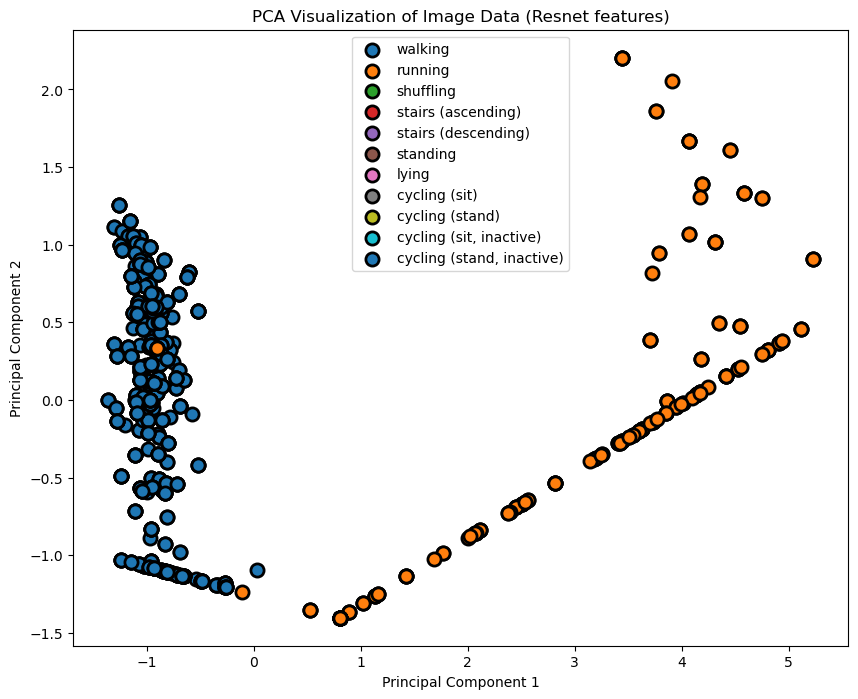

In [22]:
# Assuming your dataset has a 'classes' attribute containing class names
# class_names = dataset.clases

# Assuming you have a DataLoader named 'train_loader'
for batch in valid_loader:
    images, labels = batch
    visualize_pca(images, labels.view(-1), class_dict, attn_model)
    break  # Only visualize the first batch for simplicity

In [23]:
# Wrapper dataset class to flatten the batches
class FlattenedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.num_batches = len(original_dataset)
        self.batch_size = original_dataset[0][0].shape[0]  # Assuming shape [599, 156]

    def __len__(self):
        return self.num_batches * self.batch_size

    def __getitem__(self, idx):
        batch_idx = idx // self.batch_size
        sample_idx = idx % self.batch_size
        data_batch, label_batch = self.original_dataset[batch_idx]
        return data_batch[sample_idx], label_batch[sample_idx]

In [24]:
def load_balanced_dataset(dataset, class_counts):
    # Initialize dictionary to store indices of each class
    class_indices = {label: [] for label in class_counts.keys()}
    
    # Populate class_indices with indices of each class
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        label = label.item()  # Ensure the label is a scalar
        if label in class_indices:
            class_indices[label].append(idx)

    # Ensure each class has the required number of instances
    balanced_indices = []
    for label, count in class_counts.items():
        if len(class_indices[label]) >= count:
            balanced_indices.extend(random.sample(class_indices[label], count))
        else:
            raise ValueError(f"Not enough instances of class {label} to satisfy the requested count")

    # Create a subset of the dataset with the balanced indices
    balanced_subset = Subset(dataset, balanced_indices)
    return balanced_subset

In [25]:
class_dict = {
    0: 'walking',
    1: 'running',
    2: 'shuffling',
    3: 'stairs (ascending)',
    4: 'stairs (descending)',
    5: 'standing',
    6: 'sitting',
    7: 'lying',
    8: 'cycling (sit)',
    9: 'cycling (stand)',
    10: 'cycling (sit, inactive)',
    11: 'cycling (stand, inactive)'
}


In [26]:
# Define the desired count for each class
n = 1000
desired_count_per_class = {0: n, 1: n, 2: n, 3: n, 4: n, 5: n, 6: n, 7: n, 8: n, 9: n, 10: n, 11: 200}

flattened_data = FlattenedDataset(train_ds)

# Load balanced dataset
balanced_dataset = load_balanced_dataset(flattened_data, desired_count_per_class)

In [27]:
# Create a DataLoader for the balanced dataset
train_balanced_dataloader = DataLoader(balanced_dataset, batch_size=12000, shuffle=True)

# Print the labels in the balanced dataset to verify
for features_batch, labels_batch in train_balanced_dataloader:
    print(features_batch.shape)

torch.Size([11200, 156])


In [28]:
# Initialize dictionary to count occurrences of each class
label_counts = {label: 0 for label in class_dict}

# Iterate through the dataloader to count label occurrences
for _, labels in train_balanced_dataloader:
    for label in labels:
        label = label.item()  # Convert tensor to scalar
        if label in label_counts:
            label_counts[label] += 1

# Print the counts
print(label_counts)

{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000, 10: 1000, 11: 200}


In [29]:
# Function to apply PCA and visualize the results
def visualize_pca2(images, labels, class_names, model):
    # Flatten the images to vectors (assuming they are 2D images)
#     flattened_images = images.view(images.size(0), -1).numpy()

#     # Standardize the data before applying PCA
#     scaler = StandardScaler()
#     standardized_images = scaler.fit_transform(flattened_images)

    # Apply PCA
    pca = PCA(n_components=2)

    trained_pca = pca.fit(images.view(-1, images.size(-1)))
    reduced_features = trained_pca.transform(images.view(-1, images.size(-1)))
    
    # Plot the results
    plt.figure(figsize=(10, 8))
    for i in range(11):
        indices = labels == i
        count = (labels == i).sum()
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=class_names[i])

    plt.title('PCA Visualization of Image Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    
    model.eval()
    
    with torch.no_grad():
        standardized_images = model(images)

    trained_pca = pca.fit(standardized_images.view(-1, standardized_images.size(-1)))
    reduced_features = trained_pca.transform(standardized_images.view(-1, standardized_images.size(-1)))

    # Plot the results
    plt.figure(figsize=(10, 8))
    for i in range(11):
        indices = labels == i
        count = (labels == i).sum()
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=class_names[i])

    plt.title('PCA Visualization of Image Data (Resnet features)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    
    # Get explained variance ratio
    explained_variance_ratio = trained_pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    # Print explained variance ratio
    print("Explained variance ratio:", explained_variance_ratio)
    print("Cumulative explained variance:", cumulative_explained_variance)

    # Plot explained variance ratio
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

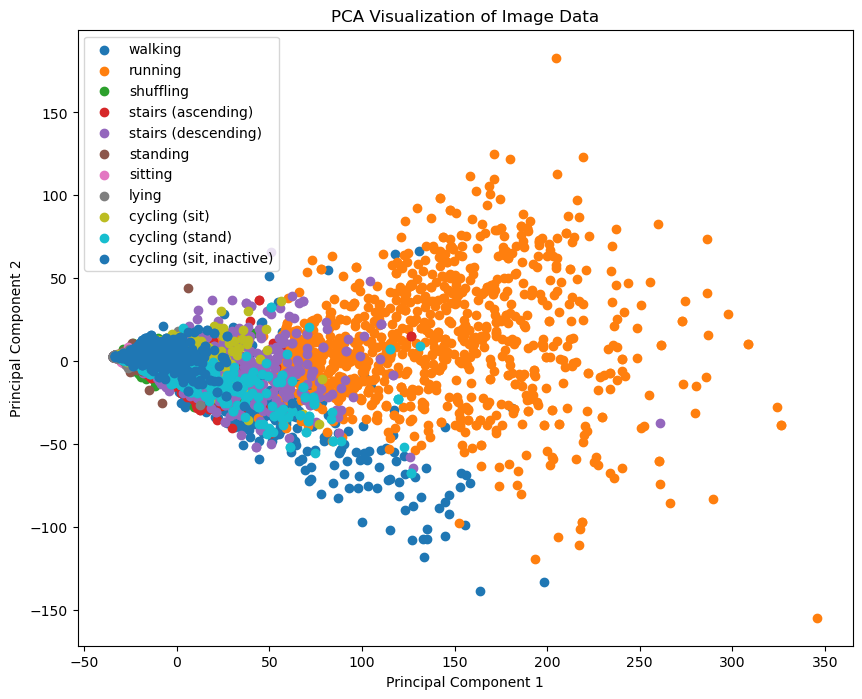

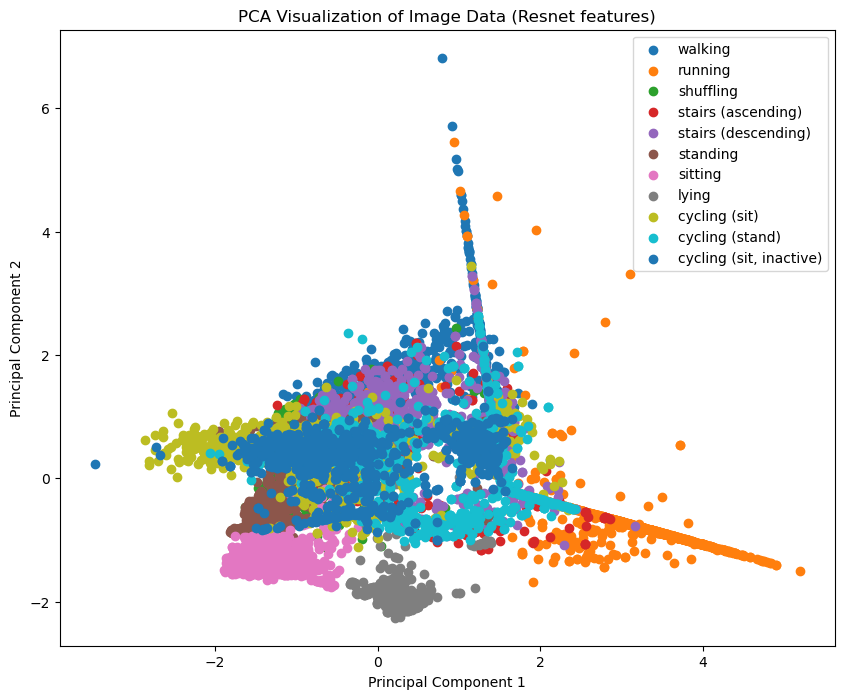

Explained variance ratio: [0.3913354  0.25964261]
Cumulative explained variance: [0.3913354  0.65097801]


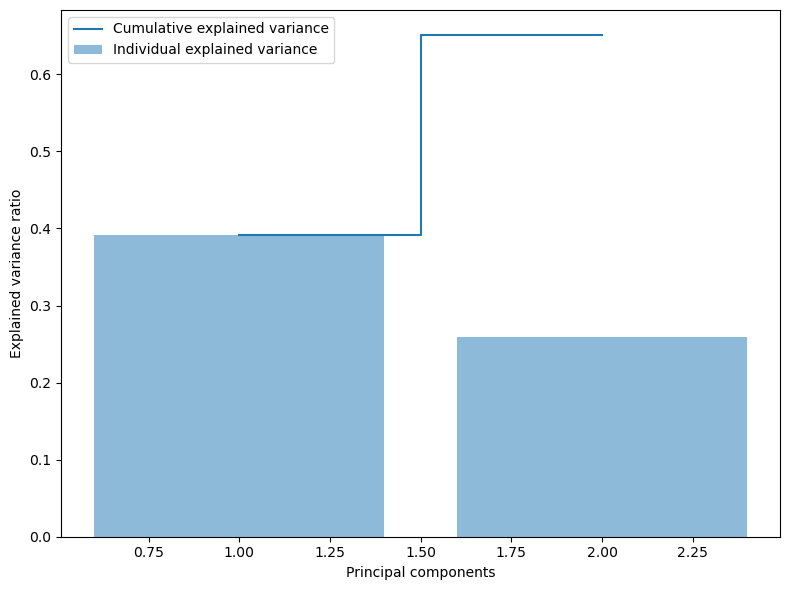

In [30]:
# Assuming your dataset has a 'classes' attribute containing class names
# class_names = dataset.clases

# Assuming you have a DataLoader named 'train_loader'
for batch in train_balanced_dataloader:
    images, labeli = batch
    images = images.view(-1, 1, images.shape[-1])
    
    visualize_pca2(images, labeli, class_dict, attn_model)

In [31]:
# Function to apply t-SNE and visualize the results
def visualize_tsne(images, labels, class_names, model):
    # Flatten the images to vectors (assuming they are 2D images)
    # Flatten the images to vectors (assuming they are 2D images)
    flattened_images = images.view(images.size(0), -1).numpy()

    # Standardize the data before applying t-SNE
    scaler = StandardScaler()
    standardized_images = scaler.fit_transform(flattened_images)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(standardized_images)

    # Plot the results
    plt.figure(figsize=(10, 8))
    for i in range(11):
        indices = labels == i
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=class_names[i])

    plt.title('t-SNE Visualization of Image Data')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()

    # Evaluate the model and get features
    model.eval()
    with torch.no_grad():
        model_features = model(images)

    # Standardize model features before applying t-SNE
    standardized_model_features = scaler.fit_transform(model_features.view(-1, model_features.size(-1)).cpu().numpy())

    # Apply t-SNE to model features
    reduced_features_model = tsne.fit_transform(standardized_model_features)

    # Plot the results
    plt.figure(figsize=(10, 8))
    for i in range(11):
        indices = labels == i
        plt.scatter(reduced_features_model[indices, 0], reduced_features_model[indices, 1], label=class_names[i])

    plt.title('t-SNE Visualization of Image Data (ResNet features)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()

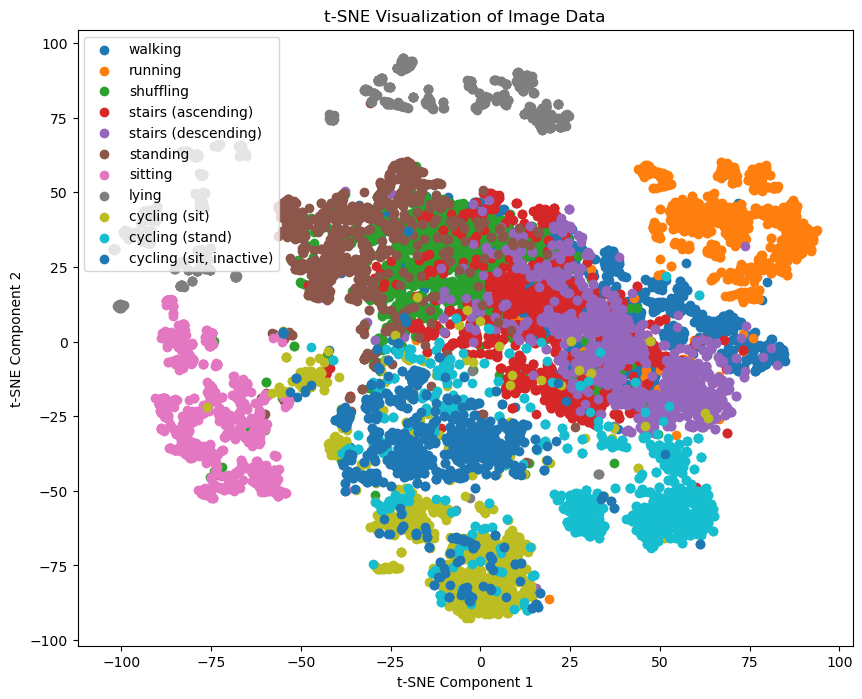

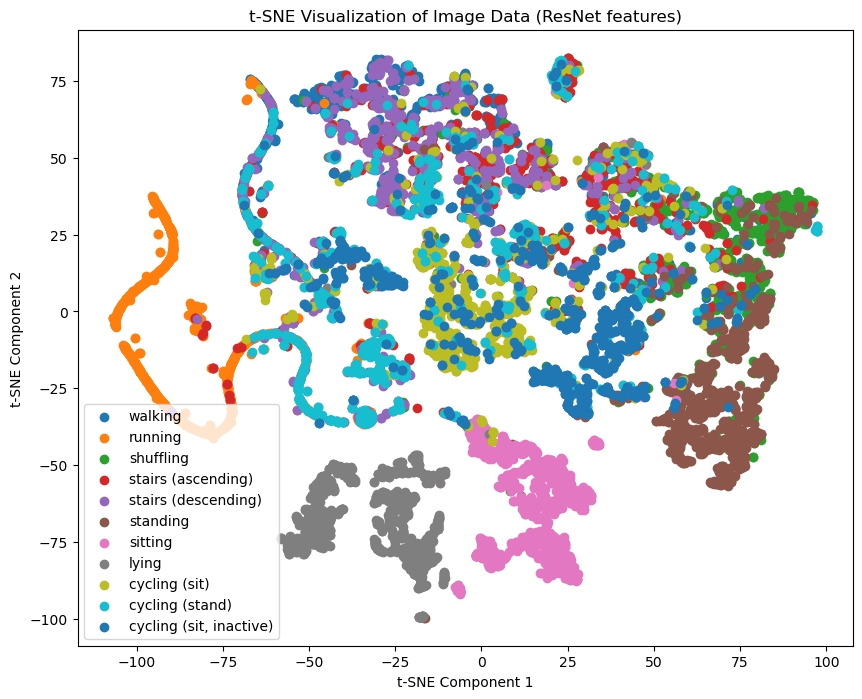

In [32]:
# Assuming your dataset has a 'classes' attribute containing class names
# class_names = dataset.clases

# Assuming you have a DataLoader named 'train_loader'
for batch in train_balanced_dataloader:
    images, labeli = batch
    images = images.view(-1, 1, images.shape[-1])
    
    visualize_tsne(images, labeli, class_dict, attn_model)

In [33]:
class LS_HATCL_LOSS(torch.nn.Module):
    def __init__(self, temperature=0.5):
        super(LS_HATCL_LOSS, self).__init__()
        self.temperature = temperature

    def forward(self, features):
        
        # Normalize the feature vectors
        features_normalized = torch.nn.functional.normalize(features, p=2, dim=-1)

        # Calculate the cosine similarity matrix
        similarities = torch.matmul(features_normalized, features_normalized.T)

        
        exp_similarities = torch.exp(similarities / self.temperature)
        
        # Removing the similarity of a window with itself i.e main diagonal
        exp_similarities = exp_similarities - torch.diag(exp_similarities.diag())        

        # Lower diagonal elements represent positive pairs
        lower_diag = torch.diagonal(exp_similarities, offset=-1)
        
        # The numerator is the sum of shifted left and right of the positive pairs
        numerator = lower_diag[1:] + lower_diag[:-1]
        
        # The denominator is the sum of the column vectors minus the positives
        denominator = torch.sum(exp_similarities[:,:-2], dim=0) - lower_diag[:-1]\
                + (torch.sum(exp_similarities[:,1:-1], dim=0)  - (lower_diag[1:] + lower_diag[:-1]))
        
        
        # Calculate NT-Xent loss
        loss = -torch.log(numerator / denominator).mean()
        
#         print("Similarities: ", similarities)
#         print("Exp Similarities: ", exp_similarities)
#         print("Numerator: ", numerator)
#         print("Denominator: ", denominator)
        
        return loss

In [34]:
class HATCL_LOSS(torch.nn.Module):
    def __init__(self, temperature=0.5):
        super(HATCL_LOSS, self).__init__()
        self.temperature = temperature

    def forward(self, features):
        # Normalize the feature vectors
        features_normalized = F.normalize(features, dim=-1, p=2)

        # Calculate the cosine similarity matrix
        similarities = torch.matmul(features_normalized, features_normalized.T)
        
        exp_similarities = torch.exp(similarities / self.temperature)
        
        # Removing the similarity of a window with itself i.e main diagonal
        exp_similarities = exp_similarities - torch.diag(exp_similarities.diag())        

        # Lower diagonal elements represent positive pairs
        positives = torch.diagonal(exp_similarities, offset=-1)

        # The denominator is the sum of the column vectors minus the positives
        denominator = torch.sum(exp_similarities[:,:-1], dim=0) - positives
        
        # Calculate NT-Xent loss
        loss = -torch.log(positives / denominator).mean()

        return loss

In [37]:
def initialize_model(seed):
    set_seed(seed)
    model = FeatureProjector(input_size=156, output_size=32)
    return model

In [38]:
# Instantiate the model
seed = 42
attn_model = initialize_model(seed)

In [39]:
# Define loss function and optimizer
cl_loss = LS_HATCL_LOSS(temperature=0.1)
optimizer = optim.AdamW(attn_model.parameters(), lr=0.01)  # Example optimizer

# Move model to device
device = torch.device("cpu" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu")
attn_model.to(device)

# Training and validation loop
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    attn_model.train()  # Set the model to training mode
    train_running_loss = 0.0

    for batch_idx, (time_series, labels) in enumerate(tqdm(train_loader)):
        time_series = time_series.to(device)
        
        # Forward pass
        features = attn_model(time_series)

        # Flatten features to have dimensions [batch_size * sequence_length, feature dim]
        features = features.reshape(-1, features.size(-1))

        # Compute training loss
        train_loss = cl_loss(features)

        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()



        # Update training statistics
        train_running_loss += train_loss.item() * time_series.size(0)

#         # Log training loss to Wandb
#         if config.WANDB and batch_idx % 10 == 0:
#             wandb.log({'Train Loss': train_running_loss /(batch_idx + 1), 'Epoch': epoch})


    train_epoch_loss = train_running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_epoch_loss:.4f}")

  0%|                                                                                                                                                              | 0/1067 [00:12<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/shamba/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main

    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/shamba/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/shamba/Desktop/SelfPAB/src/data.py", line 11, in <module>
    import src.utils
  File "/Users/shamba/Desktop/SelfPAB/src/utils.py", line 7, in <module>
    import wandb
  File "/Users/shamba/anaconda3/lib/python3.11/site-packages/wandb/__init__.py", line 20, in <module>
    from wandb import sdk as wandb_sdk
  File "/Users/shamba/anaconda3/lib/python3.1

KeyboardInterrupt: 

In [ ]:
# Instantiate the model
seed = 42
attn_model = initialize_model(seed)

In [ ]:
# Define loss function and optimizer
cl_loss = LS_HATCL_LOSS(temperature=0.5)
optimizer = optim.AdamW(attn_model.parameters(), lr=0.001)  # Example optimizer

# Move model to device
device = torch.device("cpu" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu")
attn_model.to(device)

# Training and validation loop
num_epochs = 50
mask_fraction = 1e-5
l = 1e-30

for epoch in range(num_epochs):
    # Training phase
    attn_model.train()  # Set the model to training mode
    train_running_loss = 0.0

    for batch_idx, (time_series, labels) in enumerate(tqdm(train_loader)):
        time_series = time_series.to(device) 

        # Create a mask tensor with the same shape as the original tensor
        mask = torch.rand(time_series.shape) < mask_fraction
        mask = mask.to(device)

        # Apply the mask to the original tensor (e.g., setting masked values to -1)
        masked_tensor = torch.where(mask, torch.tensor(0), time_series).to(device)

        # Forward pass
#         features = attn_model(time_series)
        masked_features = attn_model(masked_tensor)

        # Flatten features to have dimensions [batch_size * sequence_length, feature dim]
#         features = features.reshape(-1, features.size(-1))
        masked_features = masked_features.reshape(-1, masked_features.size(-1))
        time_series = time_series.reshape(-1, time_series.size(-1))
        
        linear_layer = nn.Linear(in_features=time_series.shape[-1], out_features=32)

        scaled_timeseries = linear_layer(time_series.float())
        # Compute training loss
        
        contrastive_loss = cl_loss(masked_features)
        mse_loss = F.mse_loss(scaled_timeseries, masked_features)
    
        
        train_loss = l*mse_loss + (1-l)*contrastive_loss
#         train_loss = mse_loss
        

        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Update training statistics
        train_running_loss += train_loss.item() * time_series.size(0)

#         # Log training loss to Wandb
#         if config.WANDB and batch_idx % 10 == 0:
#             wandb.log({'Train Loss': train_running_loss /(batch_idx + 1), 'Epoch': epoch})


    train_epoch_loss = train_running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_epoch_loss:.4f}")

In [ ]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(images.squeeze(), labeli)
ch_index = calinski_harabasz_score(images.squeeze(), labeli)
slh_index = silhouette_score(images.squeeze(), labeli)

print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski Harabasz Index: {ch_index}")
print(f"Silhouette Index: {slh_index}")

In [ ]:
attn_model.eval()
with torch.no_grad():
    features = attn_model(images)

In [ ]:
kmeans = KMeans(n_clusters=11, random_state=1).fit(features.detach().squeeze())
cluster_labels = kmeans.labels_

# Calculate Davies-Bouldin Index
db_index2 = davies_bouldin_score(features.detach().squeeze(), cluster_labels)
ch_index2 = calinski_harabasz_score(features.detach().squeeze(), cluster_labels)
slh_index2 = silhouette_score(features.detach().squeeze(), cluster_labels)

print(f"Davies-Bouldin Index Features: {db_index2}")
print(f"Calinski Harabasz Index Features: {ch_index2}")
print(f"Silhouette Index Features: {slh_index2}")

In [ ]:
visualize_tsne(images, labeli, class_dict, attn_model)

## Linear Evaluation

In [76]:
# Example: Define a frozen backbone and a linear classifier
class LinearEvaluation(nn.Module):
    def __init__(self, backbone, num_classes):
        super(LinearEvaluation, self).__init__()
        self.backbone = backbone
        self.backbone.requires_grad_(False)
        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.classifier = nn.Linear(32, num_classes)  # Add linear classifier
    
    def forward(self, x):
        with torch.no_grad():  # Ensure backbone is not updated
            features = self.backbone(x)  # Extract features using frozen backbone
#             features = self.bn1(features)
        return self.classifier(features)  # Feed features to linear classifier

In [85]:
def linear_evaluation(train_loader, valid_loader, algorithms, seeds, num_epochs):
    diction_algs = {}
        
    
    for alg in algorithms:
        seed_acc = []
        seed_f1 = []
        seed_prec = []
        seed_recall = []
        
        for seed in seeds:
            set_seed(seed)
            frozen_backbone = FeatureProjector(input_size=156, output_size=32)
            frozen_backbone.load_state_dict(torch.load(f'models/my_models/harth{seed}_{alg}_model_epoch_500.pth',
                                            map_location=torch.device('cpu')))
            
            
            num_activities = 12
            mine_model = LinearEvaluation(frozen_backbone, num_classes=num_activities)
            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(mine_model.parameters(), lr=0.001)  # Example optimizer

            # Move model to device
            device = torch.device("cpu" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu")
            mine_model.to(device)

            # Training and validation loop
            num_epochs = num_epochs
            for epoch in tqdm(range(num_epochs)):
                # Training phase
                mine_model.train()  # Set the model to training mode
                train_running_loss = 0.0
                train_correct_predictions = 0
                train_total_samples = 0

                all_preds = []
                all_labels = []

                for time_series, labels in (train_loader):
                    time_series = time_series.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    features = mine_model(time_series)
                    # Flatten y_hat to have dimensions [batch_size * sequence_length, num_classes]
                    y_hat_flat = features.reshape(-1, features.size(-1))

                    # Reshape y to have dimensions [batch_size * sequence_length]
                    labels_flat = labels.view(-1)

                    # Compute training loss
                    train_loss = criterion(y_hat_flat, labels_flat)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    train_loss.backward()
                    optimizer.step()

                    # Update training statistics
                    train_running_loss += train_loss.item() * time_series.size(0)

                    _, predicted = torch.max(y_hat_flat, 1)
                    train_correct_predictions += (predicted == labels_flat).sum().item()

                    #Store the labels for future computation of F1-score
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels_flat.cpu().numpy())

                    train_total_samples += labels_flat.size(0)

                # Calculate average training loss and accuracy for the epoch
                train_epoch_loss = train_running_loss / len(train_loader.dataset)
                train_epoch_accuracy = 100*train_correct_predictions / train_total_samples

                f1 = f1_score(all_labels, all_preds,average='weighted')

#                 print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_epoch_loss:.4f},\
#                       Train Accuracy: {train_epoch_accuracy:.2f}%, F1-score: {f1:.4f}")
                
            # Validation phase
            mine_model.eval()  # Set the model to evaluation mode
            val_running_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad():
                val_preds = []
                val_labels = []
                for time_series, labels in (valid_loader):
                    time_series = time_series.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    features = mine_model(time_series)

                    # Flatten y_hat to have dimensions [batch_size * sequence_length, num_classes]
                    y_hat_flat = features.reshape(-1, features.size(-1))

                    # Reshape y to have dimensions [batch_size * sequence_length]
                    labels_flat = labels.view(-1)

                    # Compute validation loss
                    val_loss = criterion(y_hat_flat, labels_flat)

                    # Update validation statistics
                    val_running_loss += val_loss.item() * time_series.size(0)

                    _, predicted = torch.max(y_hat_flat, 1)
                    val_correct_predictions += (predicted == labels_flat).sum().item()
                    val_total_samples += labels_flat.size(0)

                    val_preds.extend(predicted.cpu().numpy())
                    val_labels.extend(labels_flat.cpu().numpy())

            # Calculate average validation loss and accuracy for the epoch
            val_epoch_loss = val_running_loss / len(valid_loader.dataset)
            val_epoch_accuracy = 100*val_correct_predictions / val_total_samples

            # Precision and recall using sklearn
            precision = precision_score(val_labels, val_preds, average='macro')
            recall = recall_score(val_labels, val_preds, average='macro')

            f1 = f1_score(val_labels, val_preds, average='weighted')
#             print(f"Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_epoch_loss:.4f},\
#                   Val Accuracy: {val_epoch_accuracy:.2f}%, F1-score: {f1:.2f},\
#                   Precision: {precision:.2f}, Recall: {recall:.2f}")
            
            
            seed_acc.append((round(val_epoch_accuracy,2)))
            seed_f1.append((round(f1,2)))
            seed_prec.append((round(precision,2)))
            seed_recall.append((round(recall,2)))
            
            
        diction_algs[f'{alg}'] = [(round(np.mean(seed_acc),2), round(np.std(seed_acc),2)),
                                   (round(np.mean(seed_f1),2), round(np.std(seed_f1),2)),
                                   (round(np.mean(seed_prec),2), round(np.std(seed_prec),2)),
                                   (round(np.mean(seed_recall),2), round(np.std(seed_recall),2))]
        
    return diction_algs

In [95]:
algorithms = ['cost']
seeds = [42, 53, 64, 75]
num_epoch = 50

In [96]:
metric_data = linear_evaluation(train_loader, valid_loader, algorithms, seeds, num_epoch)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [21:41<00:00, 26.02s/it]
/Users/shamba/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [22:01<00:00, 26.43s/it]
/Users/shamba/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

python(34017) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34023) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 32/50 [59:33<08:11, 27.28s/it]python(34032) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34036) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34040) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34043) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34047) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34053) MallocStackLog

python(34372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34382) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 39/50 [1:03:10<05:46, 31.48s/it]python(34388) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34391) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34413) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34438) MallocStackLog

python(34677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 46/50 [1:06:30<01:52, 28.07s/it]python(34682) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34685) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34695) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34698) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34701) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34704) MallocStackLog

In [98]:
metric_data

{'cost': [(32.74, 9.67), (0.26, 0.06), (0.17, 0.02), (0.15, 0.02)]}

In [65]:
# Function to apply t-SNE and visualize the results
def visualize_tsne123(images, colors, labels, class_names, model):

    # Evaluate the model and get features
    model.eval()
    with torch.no_grad():
        model_features = model(images)

    # Standardize the data before applying t-SNE
    scaler = StandardScaler()
    tsne = TSNE(n_components=2, init='random', learning_rate='auto')

    # Standardize model features before applying t-SNE
    standardized_model_features = scaler.fit_transform(model_features.view(-1, model_features.size(-1)).cpu().numpy())

    # Apply t-SNE to model features
    reduced_features_model = tsne.fit_transform(standardized_model_features)

    # Plot the results
    plt.figure(figsize=(6, 6))
    for i, val in enumerate([0, 1, 5,6]):
        indices = labels == val
        plt.scatter(reduced_features_model[indices, 0], reduced_features_model[indices, 1], color =colors[i], label=class_names[val])

#     plt.title('t-SNE Visualization of Image Data (ResNet features)')
#     plt.xlabel('t-SNE Component 1')
#     plt.ylabel('t-SNE Component 2')
    plt.legend()
    
    plt.legend(prop={'size': 14, 'family': 'Tahoma'})
    plt.show()

In [66]:
model = FeatureProjector(input_size=156, output_size=32)

In [67]:
algorithms = ['vanilla', 'tnc', 'cpc', 'ts2vec', 'infoTS', 'triplet', 'doubleCL', 'marginCL', 'recons', 'monoselfPAB']

In [72]:
model.load_state_dict(torch.load(f'models/my_models/harth53_cost_model_epoch_500.pth',
                                            map_location=torch.device('cpu')))

<All keys matched successfully>

In [73]:
class_dict = {
    0: 'walking',
    1: 'running',
    2: 'shuffling',
    3: 'stairs (ascending)',
    4: 'stairs (descending)',
    5: 'standing',
    6: 'sitting',
    7: 'lying',
    8: 'cycling (sit)',
    9: 'cycling (stand)',
    10: 'cycling (sit, inactive)',
    11: 'cycling (stand, inactive)'
}


In [74]:
# Assuming your dataset has a 'classes' attribute containing class names
# class_names = dataset.clases

# Assuming you have a DataLoader named 'train_loader'
for batch in train_balanced_dataloader:
    images, labeli = batch
    images = images.view(-1, 1, images.shape[-1])

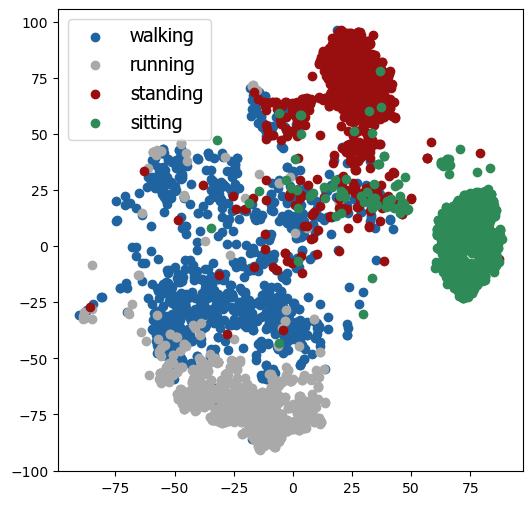

In [75]:
# Define your class names and corresponding colors for 5 classes
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
colors = ['#1F64A1', '#A9A9A9', '#990F0F', '#2E8B57']  # Blue, Light Gray, Red, Green, Cyan

# Assume `images`, `labels`, and `model` are already defined
# `labeli` corresponds to the labels for the images, `class_dict` is a dictionary mapping labels to class names
visualize_tsne123(images, colors, labeli, class_dict, model)
